In [1]:
from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy import units as au
from astropy import stats
import scipy as sp
from scipy import ndimage
from spectral_cube import SpectralCube

from astrodendro.analysis import PPStatistic
from astrodendro import Dendrogram, pp_catalog

import aplpy

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 


In [2]:
# def pruneleaves(index_map, props):
#     """Return index array containing only leaves"""
#     for x in range(index_map.shape[0]):
#         for y in range(index_map.shape[1]):
#             if index_map[x,y] not in list(props['_idx']):
#                 index_map[x,y] = -1
#     return(index_map)

def pruneleaves(index_map, props):
    """Return index array containing only leaves"""
    
#     noneleafmask = index_map.copy()
    
#     for idx in list(props['_idx']): 
#         mask = index_map == idx 
#         noneleafmask[mask] = False
#     noneleafmask[noneleafmask!=False] = True
    
#     index_map[noneleafmask] = -1
    
    for x in range(index_map.shape[0]):
        for y in range(index_map.shape[1]):
            if index_map[x,y] not in list(props['_idx']):
                index_map[x,y] = -1
                
    return(index_map)

In [3]:
inputfile = './../../hst_contsub/550m814w/ngc1672_halpha_final.fits'
hdu = fits.open(inputfile)[0]

inputfile = './../../hst_contsub/550m814w/ngc1672_cont.fits'
hdu_cont = fits.open(inputfile)[0]

In [4]:
"""Cut out excess nan values around edge of map"""

hdu_tmp = hdu.copy()
hdu_tmp.data = [hdu_tmp.data, hdu_tmp.data]

hdu_tmp.header['CDELT3'] = 1
hdu_tmp.header['CRPIX3'] = 1
hdu_tmp.header['CRVAL3'] = 1
hdu_tmp.header['CUNIT3'] = 'km/s'
hdu_tmp.header['CTYPE3'] = 'VELO'

cube = SpectralCube.read(hdu_tmp)
cube = cube.subcube_from_ds9region('fk5; box(4:45:51.4903,-59:14:26.075,90.716",102.162",359.99999)')

hdu_tmp = cube.hdu 
hdu_tmp.data = hdu_tmp.data[0]
del hdu_tmp.header['*3']
hdu_tmp.header['WCSAXES'] = 2

hdu = hdu_tmp
hdu_tmp.writeto('./ngc1672_halpha_testregion.fits', overwrite=True)

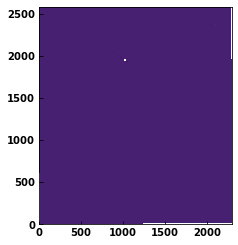

In [5]:
plt.imshow(hdu.data, origin='lower')

In [6]:
header = hdu.header
wcs = WCS(header)
data = hdu.data
data = np.squeeze(data)

pixsize = np.array([-1*header['CDELT1'], header['CDELT2']]).mean() *au.degree
bmaj = 0.05 *au.arcsec
bmin = 0.05 *au.arcsec

# mask = hdu_cont.data<0
# std = stats.mad_std(data[mask], ignore_nan=True)
std = stats.mad_std(data, ignore_nan=True)

In [7]:
min_value = std*2
min_delta = std*10
min_npix  = 9

In [8]:
dendro = Dendrogram.compute(data,
                min_delta=min_delta,
                min_value=min_value,
                min_npix=min_npix,
                wcs=wcs)

metadata = {}
metadata['data_unit'] = au.Jy / au.beam
metadata['spatial_scale'] =  pixsize.to('arcsec')
metadata['beam_major'] =  bmaj.to('arcsec')
metadata['beam_minor'] =  bmin.to('arcsec')
    
props = pp_catalog(dendro, metadata, verbose=False)

In [9]:
# v = dendro.viewer()
# v.show()

In [10]:
index_map = dendro.index_map
# # index_map = pruneleaves(index_map, props)
# plt.imshow(index_map)
# index_map_hdu = fits.PrimaryHDU(index_map, header=header)
# index_map_hdu.writeto('tmp.fits', overwrite=True)

INFO: Auto-setting vmin to -7.034e-19 [aplpy.core]
INFO: Auto-setting vmax to  6.612e-18 [aplpy.core]
INFO: Auto-setting vmin to  5.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.809e+02 [aplpy.core]


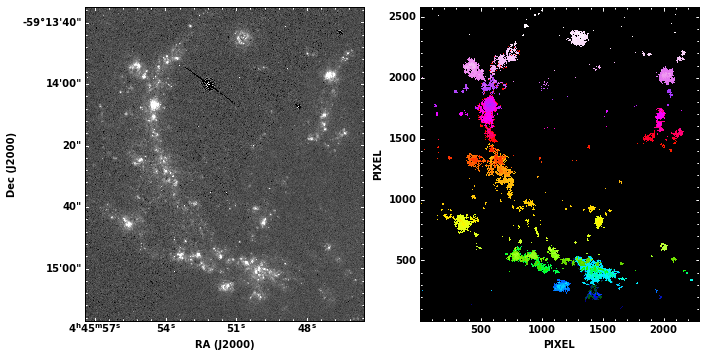

In [11]:
index_map = np.array(index_map, dtype=float)
index_map[index_map==-1] = np.nan

from matplotlib.pyplot import cm

fig = plt.figure(figsize=(11,10))
ax1 = aplpy.FITSFigure(hdu, figure=fig, subplot=(1,2,1))
ax2 = aplpy.FITSFigure(index_map, figure=fig, subplot=(1,2,2))

ax1.show_grayscale(stretch='sqrt')
ax2.show_colorscale(cmap='gist_ncar', stretch='sqrt')
ax2.set_nan_color('black')

fig.savefig('dendro.pdf', bbox_inches='tight')

In [12]:
from scimes import SpectralCloudstering

SAVE_ALL_LEAVES triggered: isolated leaves and unclustered leaves will be retained
- Creating affinity matrices
- Start spectral clustering
-- Rescaling flux matrix
-- Estimated scaling parameter: 0.000000
-- Guessed number of clusters = 43
-- Number of k-means iteration: 1
-- Best cluster number found through SILHOUETTE (0.934241)= 43
-- Final cluster number (after cleaning) 43
-- Final clustering configuration silhoutte 0.622726
SAVE_ISOL_LEAVES triggered. Isolated leaves added.
-- Total cluster number 301
SAVE_CLUST_LEAVES triggered. Unclustered leaves added.
-- Total cluster number 315
Generate assignment cubes...


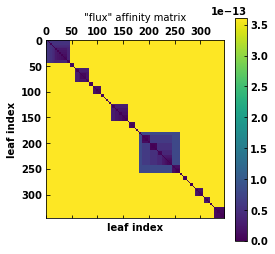

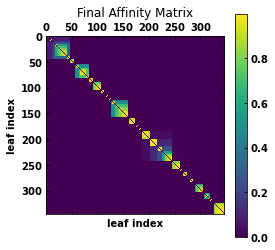

In [13]:
dclust = SpectralCloudstering(dendro, props, header, criteria = ['flux'], save_all_leaves=True)

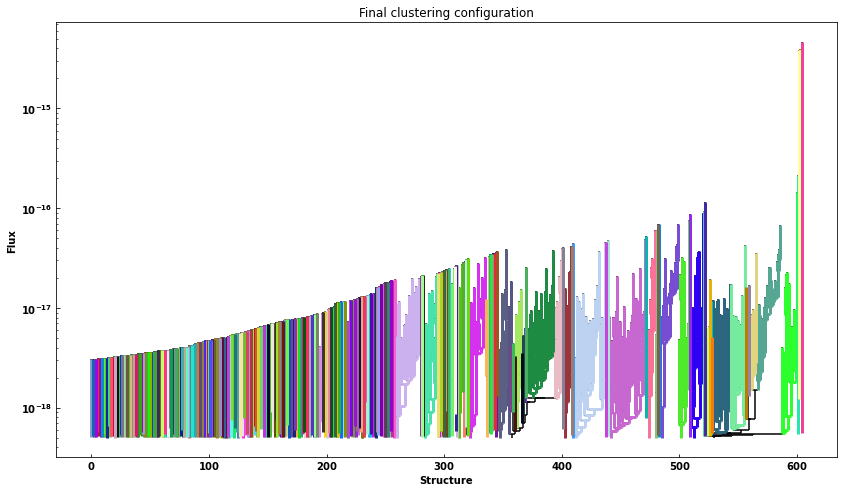

In [14]:
dclust.showdendro()

INFO: Auto-setting vmin to -7.038e-19 [aplpy.core]
INFO: Auto-setting vmax to  6.224e-18 [aplpy.core]


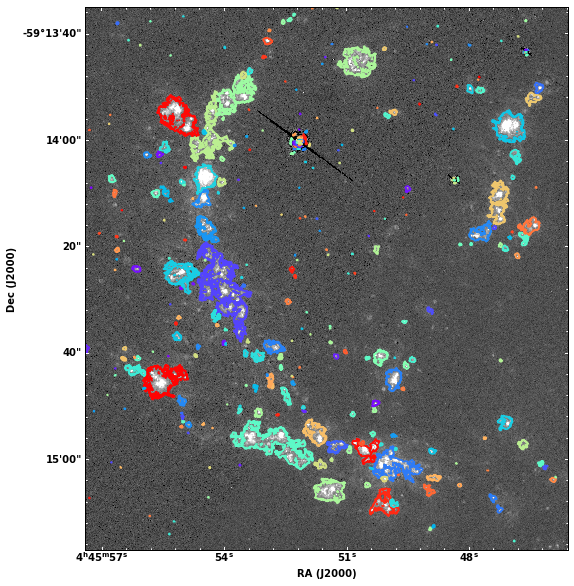

In [15]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(10,10))
ax = aplpy.FITSFigure(hdu, figure=fig)
ax.show_grayscale(stretch='sqrt')

idx = list(np.unique(dclust.clusters_asgn.data))
idx.remove(-1)
color = cm.rainbow(np.linspace(0, 1, len(idx)))

for i, idx_ in enumerate(idx): 
#     print(idx_)
    contours = dclust.clusters_asgn.data.copy()
    contours[contours!=idx_] = -1
    ax.show_contour(contours, colors=matplotlib.colors.rgb2hex(cm.rainbow(np.random.random())), levels=[idx_], linestyles='-')
#     ax.show_contour(contours, colors=matplotlib.colors.rgb2hex(color[i]), levels=[idx_], linestyles='-')

fig.savefig('tmp.pdf', bbox_inches='tight')

In [16]:
# plt.figure(figsize=(10,10))
# plt.imshow(dendro.index_map, origin='lower', cmap='gist_rainbow', vmin=0)

In [17]:
# plt.figure(figsize=(10,10))
# plt.imshow(dclust.leaves_asgn.data, origin='lower', cmap='gist_rainbow')

In [18]:
# plt.figure(figsize=(10,10))
# plt.imshow(dclust.trunks_asgn.data, origin='lower', cmap='gist_rainbow')

In [19]:
# plt.figure(figsize=(10,10))
# plt.imshow(dclust.clusters_asgn.data, origin='lower', cmap='gist_rainbow')

In [20]:
dclust.clusters_asgn.writeto('dclust.clusters_asgn.fits', overwrite=True)